# Multimodal Analyses between RNA, Metadata, and Metabolite Datasets
**Goal 1:** Identify correlations between RNA and Metabolite across 3 different subsets of genes. 

**Goal 2:** Identify correlation between RNA and Metabolite while controlling for metadata covariates

**Dataset:** Metabolite Dataset, Normalized RNA Dataset, Metadata from the CCLE

**Interest:** Information Overlap between RNA and Metabolite, RNA and Metabolite while controlling for covariates

**Import necessary packages**

In [1]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})

**Read in model (stored in IPython kernel memory)**

In [2]:
store -r model

**Read in model (from file)**

In [4]:
import cobra
from cobra.io import load_matlab_model
model = load_matlab_model("../Models/GEM_Recon2_thermocurated_redHUMAN.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
This model seems to have metHMDB instead of metHMDBID field. Will use metHMDB for what metHMDBID represents.
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, x


**Use ./general_functions.ipynb to define necessary functions**

In [3]:
%run "./general_functions.ipynb"

**Rename genes in metabolic model based on Entrez to Gene Name(Hugo Symbol) conversion file**

In [4]:
conversion = pd.read_csv("../Data/entrez2protein.csv")
conversion.index = conversion["Entrez ID"]
for gene in model.genes:
    entrez_id = gene.id
    entrez_id = entrez_id.split(".")[0]
    if entrez_id.isnumeric():
        entrez_id = int(entrez_id)
        if entrez_id in list(conversion.index):
            gene_id = conversion.loc[entrez_id]["Gene Name"]
            gene.name = gene_id
        
        else:
            print("Entrez not in file")

**Import RNA, RNA key, and metabolite data files after processed**

(./RNA_processing_in_R.ipynb, ./Metabolite_Preprocessing.ipynb)

In [30]:
rData = pd.read_csv("../Data/Generated Data/CCLE_RNAseq_genes_counts_20180929.VST.normalized.csv", engine = "c")
rKey = pd.read_csv("../Data/CCLE_RNAseq_genes_counts_20180929.gct", skiprows = 2, sep = "\t")
mData = pd.read_csv("../Data/Generated Data/processed_metabolite_data.csv", engine ="c")
#rData.columns = [x[1:] for x in rData.columns]
mData = mData.transpose()
other_data = pd.read_csv("../Data/Generated Data/processed_rna_data.csv")

**Convert from Ensembl to Gene Symbol and rename cell lines for synchronicity in RNA data**

In [31]:
rData["Symbols"] = rKey["Description"]
rData = rData.drop(axis = 1, labels = "Unnamed: 0")
rData = rData.set_index("Symbols", drop = True)
new_columns = []
for name in rData.columns:
    if name[1] in ["1","2","3","4","5","6","7","8","9","0"]:
        new_columns.append(name[1:])
    else:
        new_columns.append(name)
rData.columns = new_columns

In [32]:
rData.head()

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Symbols,,,,,,,,,,,,,,,,,,,,,
DDX11L1,4.144812,4.083563,3.983676,3.861639,3.233064,2.903889,3.569985,3.287129,3.579238,3.816163,...,5.583862,4.834158,6.586462,6.598611,6.101920,4.809323,5.075627,3.653465,4.882370,3.900082
WASH7P,10.033721,9.805125,9.350566,9.523673,9.934292,9.655674,9.327016,9.171688,9.412413,9.316719,...,10.251425,8.875073,10.497284,9.264383,9.135421,9.594657,9.458329,9.603615,9.645391,10.075075
MIR1302-11,3.405155,2.954959,3.360215,3.425418,3.233064,3.752773,3.406169,3.435301,3.579238,3.128966,...,5.029931,4.189340,5.938105,5.980826,5.826596,4.044624,3.894486,2.913577,4.161789,3.770791
FAM138A,3.641718,3.427916,3.168937,3.591710,2.960446,3.499127,3.406169,2.869993,3.214169,3.312271,...,5.294517,4.972926,6.258284,5.696676,6.050945,4.282196,4.613323,2.281881,4.619851,3.624516
OR4G4P,2.281881,3.225502,3.360215,2.953442,2.960446,2.281881,2.941772,3.108033,2.281881,3.128966,...,4.702167,3.579393,5.379921,4.611860,4.352559,3.564647,4.304155,3.517295,3.654838,3.247761


**Restrict data to cell lines with measurements across protein & metabolites and process duplictes**

In [46]:
cell_lines = list(set(rData.columns).intersection(set(mData.columns)))
cell_lines = [x for x in cell_lines if 'HAEMATOPOIETIC' not in x]
rna_df = rData[cell_lines]
metabolite_df = mData[cell_lines]
rna_df = rna_df.loc[:,~rna_df.columns.duplicated()]
original_rna_df = rna_df.copy()
metabolite_df = metabolite_df.loc[:,~metabolite_df.columns.duplicated()]
original_metabolite_df = metabolite_df.copy()

**Set k-case and get indices for both RNA and metabolite data**

In [47]:
rna_index = list(rna_df.index)
metabolite_index = list(metabolite_df.index)
k = 1

**Perform subsetting operation using k-case and get new subset of genes**

In [48]:
new_rna_index = subsetting(k, rna_index, metabolite_index, model)
new_rna_index = [x for x in new_rna_index if type(x) == str]

69


**Check number of genes**

In [49]:
len(new_rna_index)

714

**Remove duplicate genes**

In [50]:
rna_df = rna_df[~rna_df.index.duplicated(keep='first')]

**Remove cellular compartment suffixes from metabolites in model**

In [51]:
metabolite_names = []
for met in model.metabolites:
    met_id = "_".join(met.id.split("_")[:-1])
    if met_id not in metabolite_names and met_id in metabolite_index:
        metabolite_names.append(met_id)

**Subset to new gene subset and metabolite subset**

In [52]:
rna_list = new_rna_index
metabolite_list = metabolite_names
rna_df = rna_df.loc[rna_list]
metabolite_df = metabolite_df.loc[metabolite_list]

**Average duplicates (if any)**

In [53]:
rna_df = averageDuplicates(rna_df)

**Calculate the information overlap between RNA and metabolite after subsetting using k**

In [54]:
%%time
overlap = calcOverlap(rna_df, metabolite_df, "DC")
print("DC coeff is: %f" %overlap)

DC coeff is: 0.616180
CPU times: user 154 ms, sys: 16.8 ms, total: 171 ms
Wall time: 155 ms



**Get information overlap for permutations and graph distribution**

**Also: perform one-sample T-test between permuted overlaps and true overlap**

T-test: TtestResult(statistic=-692.2768827058196, pvalue=1.948283705365012e-99, df=49)
CPU times: user 21.8 s, sys: 55.1 s, total: 1min 16s
Wall time: 13.8 s


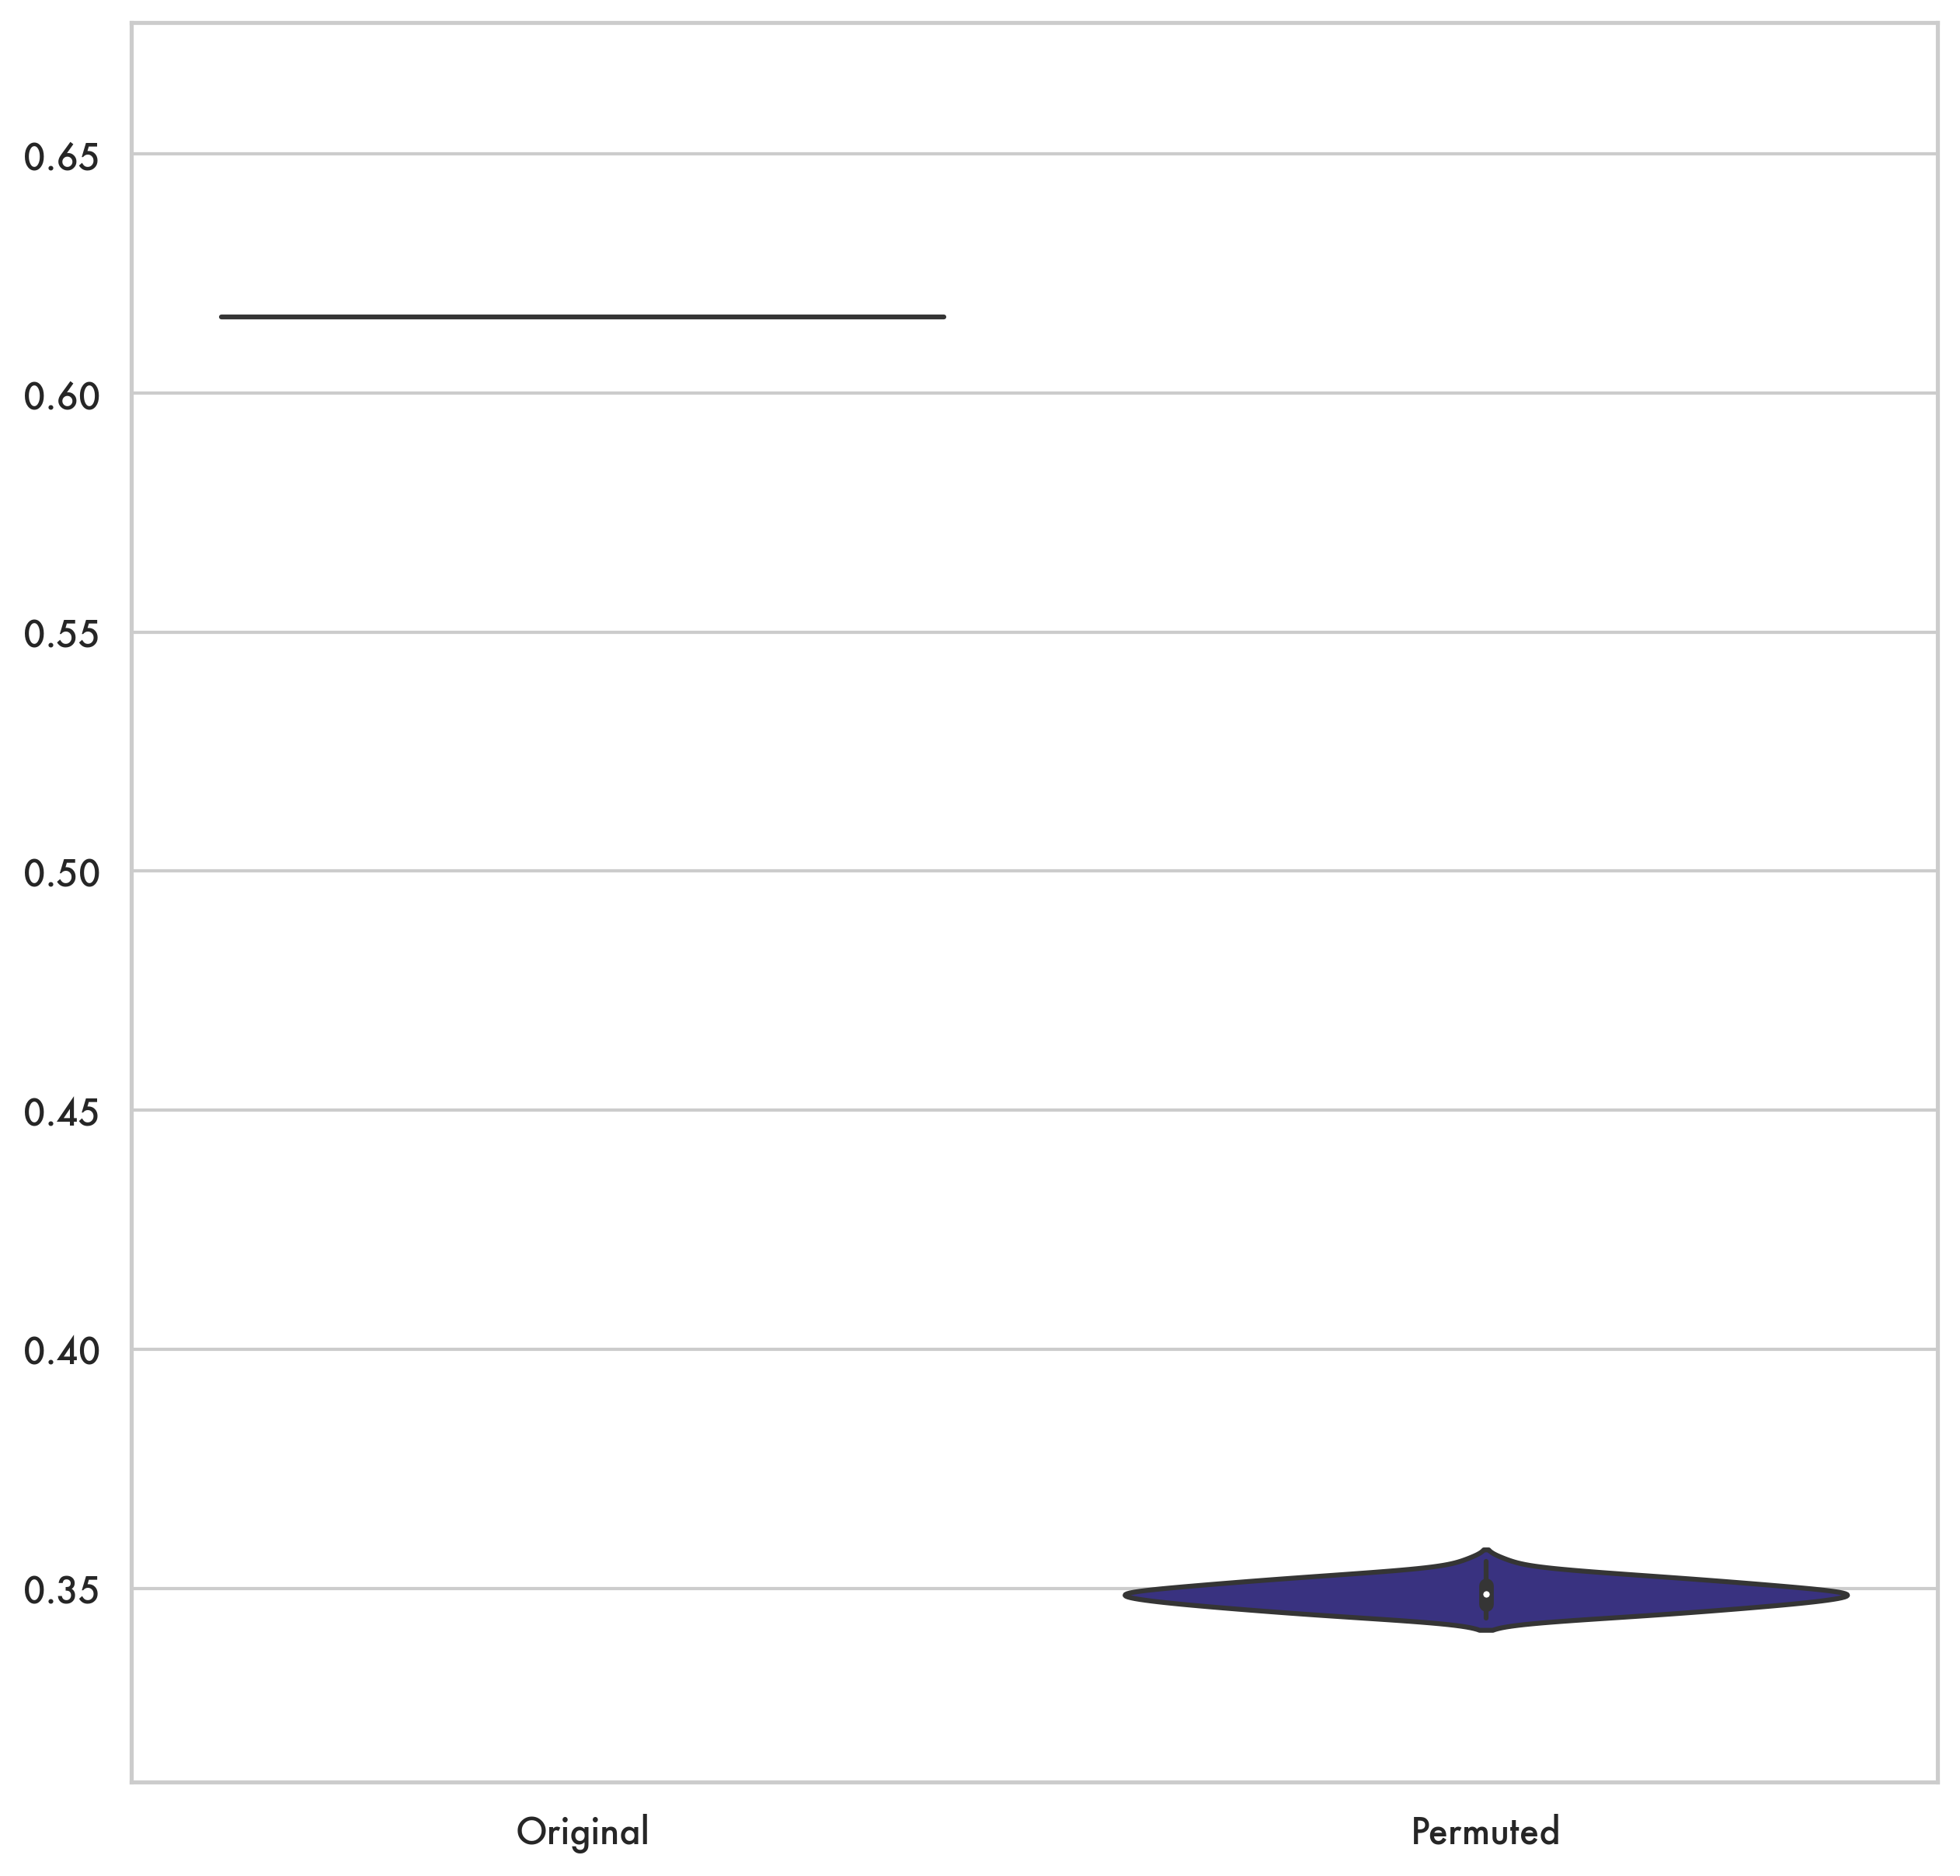

In [42]:
%%time
permutationData = permuteDataframe(rna_df, metabolite_df, 51, "DC")
permutationData["Original"] = overlap
permutationData["Permuted"] = permutationData[0]
permutationData = permutationData.drop(0, axis = 1)
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
fig1 = sns.violinplot(data = permutationData, color = "#2F258D")
fig1.set_ylim(permutationData.Permuted.min()*.9, overlap*1.1);
print("T-test: " + str(stats.ttest_1samp(list(permutationData["Permuted"]), popmean= overlap)))

**Perform gene sampling and graph distribution of information overlap**

**Also: perform one-sample T-test between sampled overlaps and true overlap**

/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_33001/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_33001/2429060530.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap


T-test: TtestResult(statistic=-13.76910375704367, pvalue=1.8187539744259445e-18, df=49)


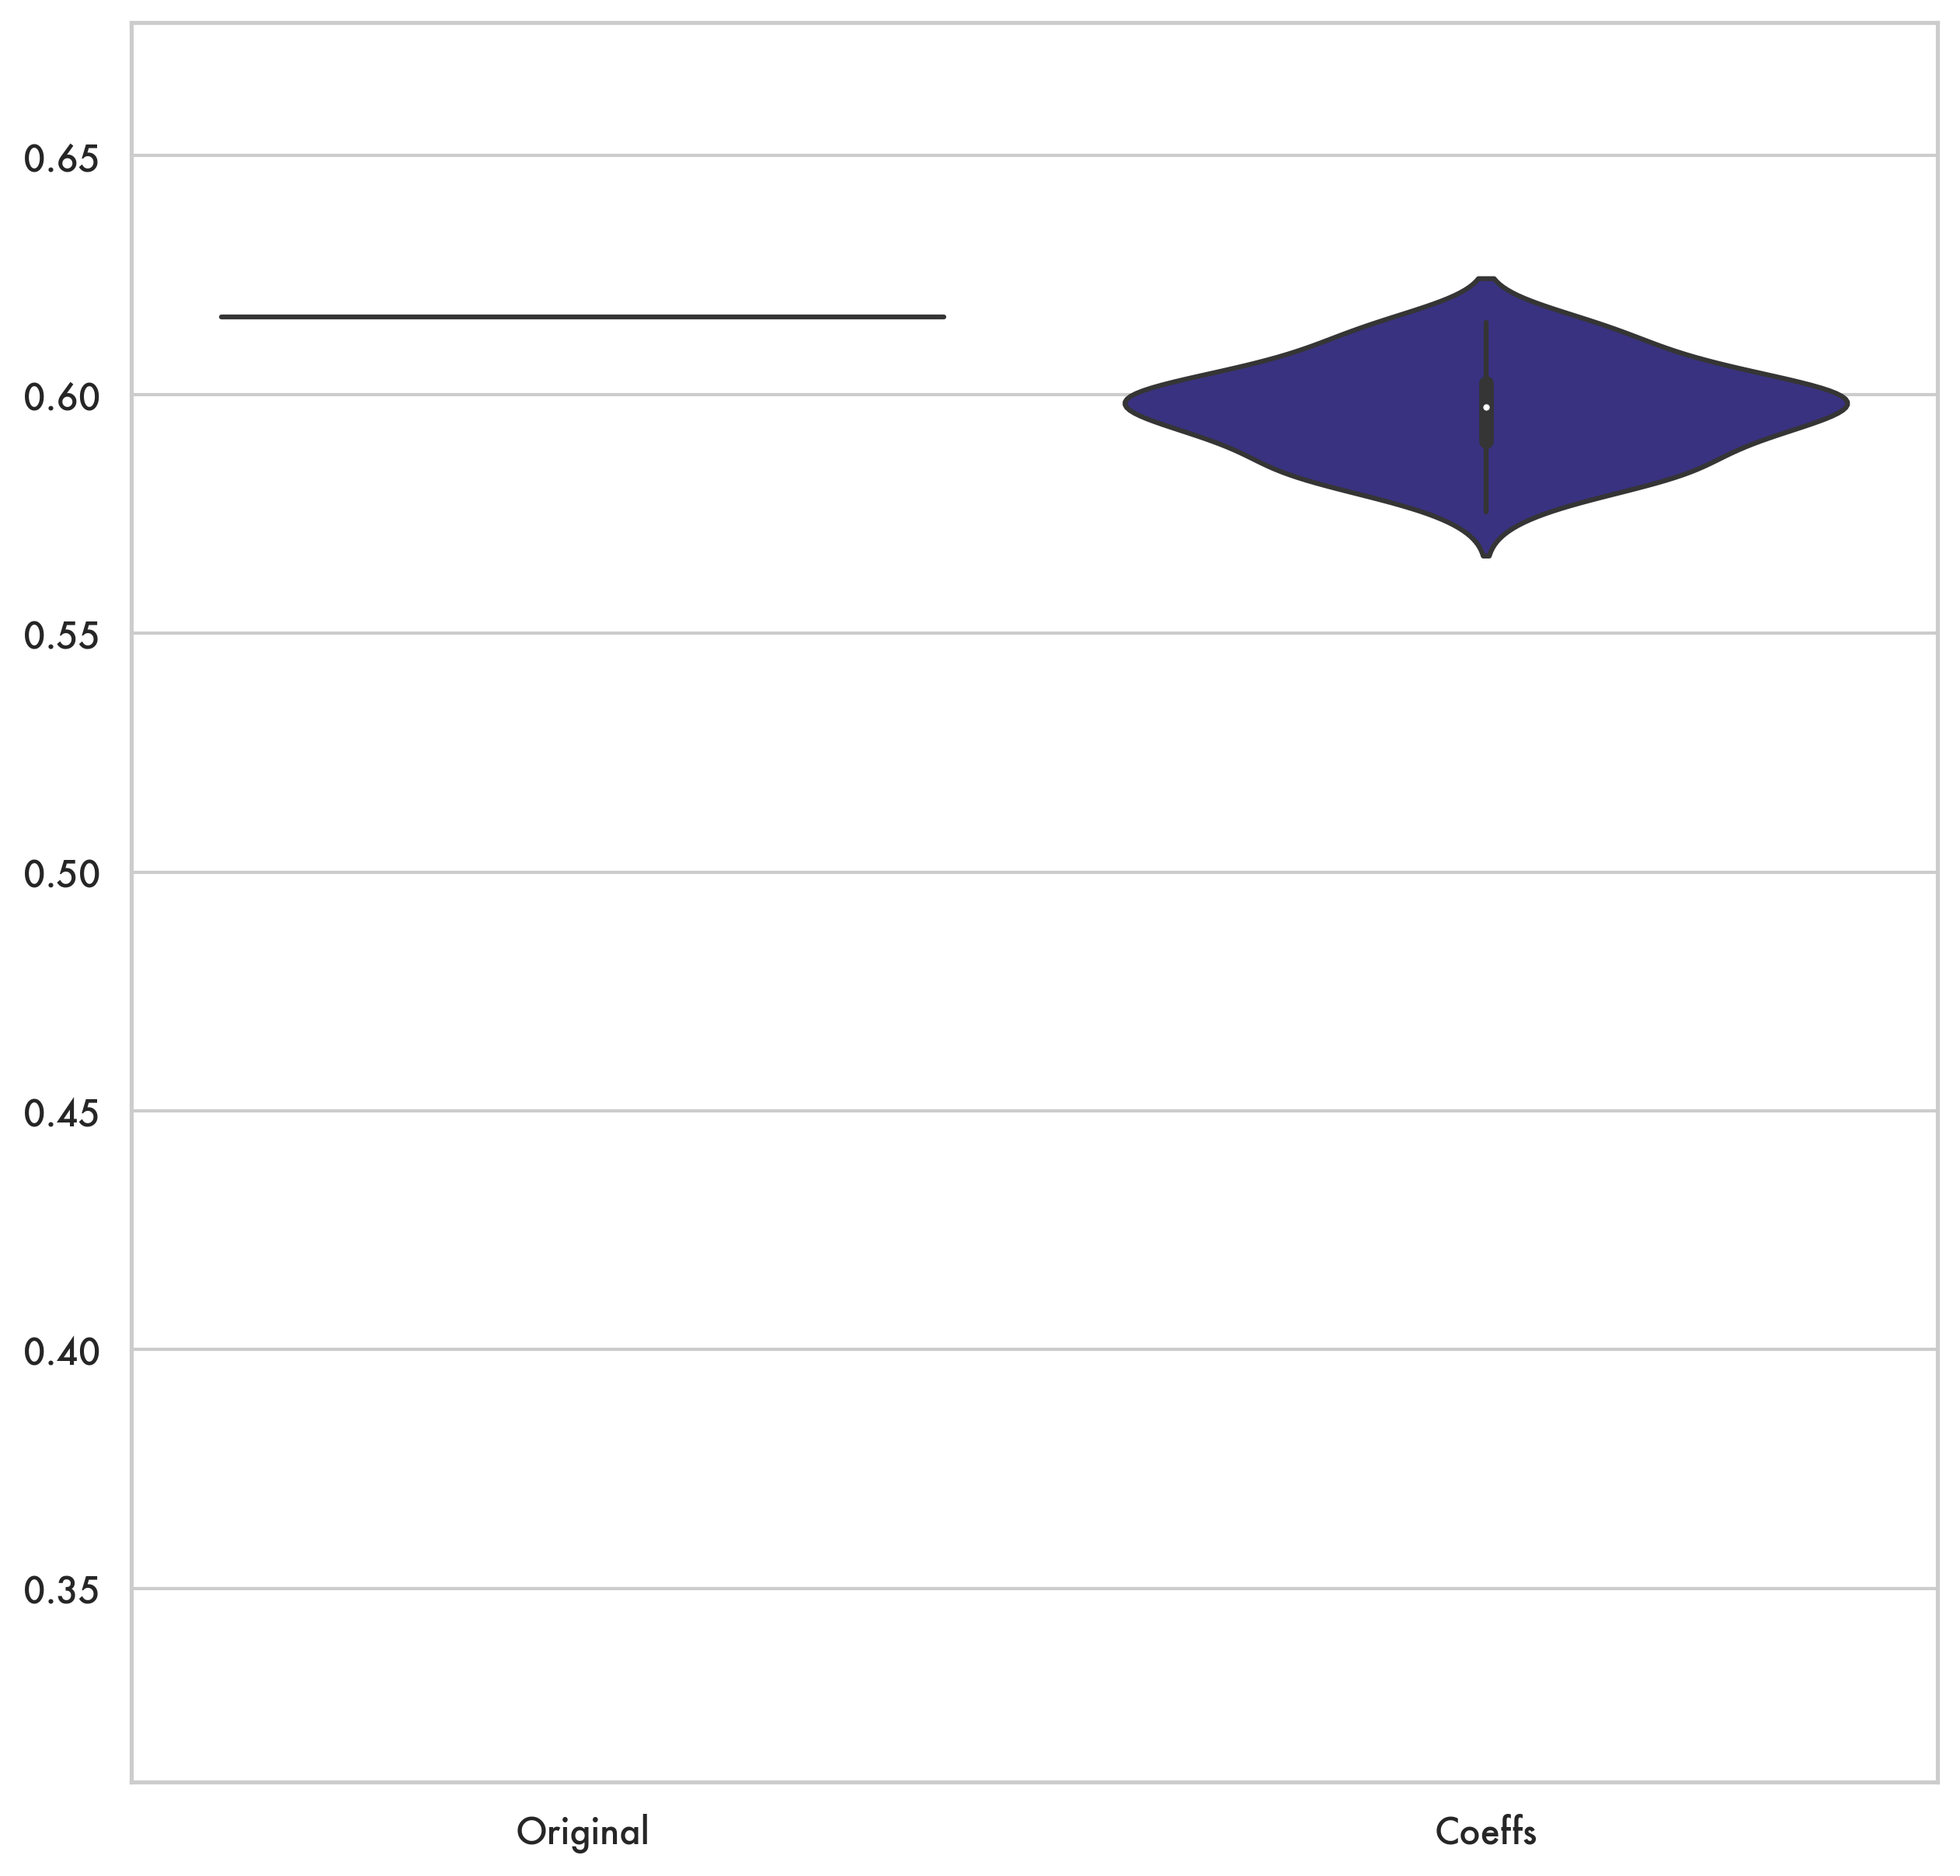

In [55]:
samplingData = geneSampling(original_rna_df, original_metabolite_df, new_rna_index, 51, "DC")
samplingData["Original"] = overlap
samplingData = samplingData.copy()
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
fig2 = sns.violinplot(data = samplingData, order = ["Original", "Coeffs"], color = "#2F258D")
fig2.set_ylim(permutationData.Permuted.min()*.9, overlap*1.1);
print("T-test: " + str(stats.ttest_1samp(list(samplingData["Coeffs"]), popmean= overlap)))

In [ ]:
%%time
permutationData = permuteDataframe(rna_df, metabolite_df, 50, "DC")


**Calculate PDC/true overlap for numerical covariates**

In [122]:
meta_data = pd.read_csv("../Data/Generated Data/meta_data.csv")
meta_data = meta_data[rna_df.columns]
meta_variables = ["mutRate", "Doubling.Time.Calculated.hrs"] + list(meta_data.iloc[-55:].index)
list_of_PDC = pd.DataFrame()
meta_data_analysis = meta_data.dropna(axis =1,subset = meta_variables)
for variable in meta_variables:
    variable_df =  meta_data_analysis.loc[variable].transpose().astype(float)
    overlap = calcOverlap(rna_df[meta_data_analysis.columns].transpose(), metabolite_df[meta_data_analysis.columns].transpose(), "DC")
    partial = calcPDC(rna_df[meta_data_analysis.columns].transpose().to_numpy(), metabolite_df[meta_data_analysis.columns].transpose().to_numpy(), variable_df)
    list_of_PDC[variable] = [partial/overlap]
list_of_PDC.loc["Partial Distance Correlation/True Distance Correlation"] = list_of_PDC.iloc[0]
list_of_PDC = list_of_PDC.loc[["Partial Distance Correlation/True Distance Correlation"]]
list_of_PDC = list_of_PDC.transpose()

**Plot distribution of these difference between true overlap and PDC across covariates**

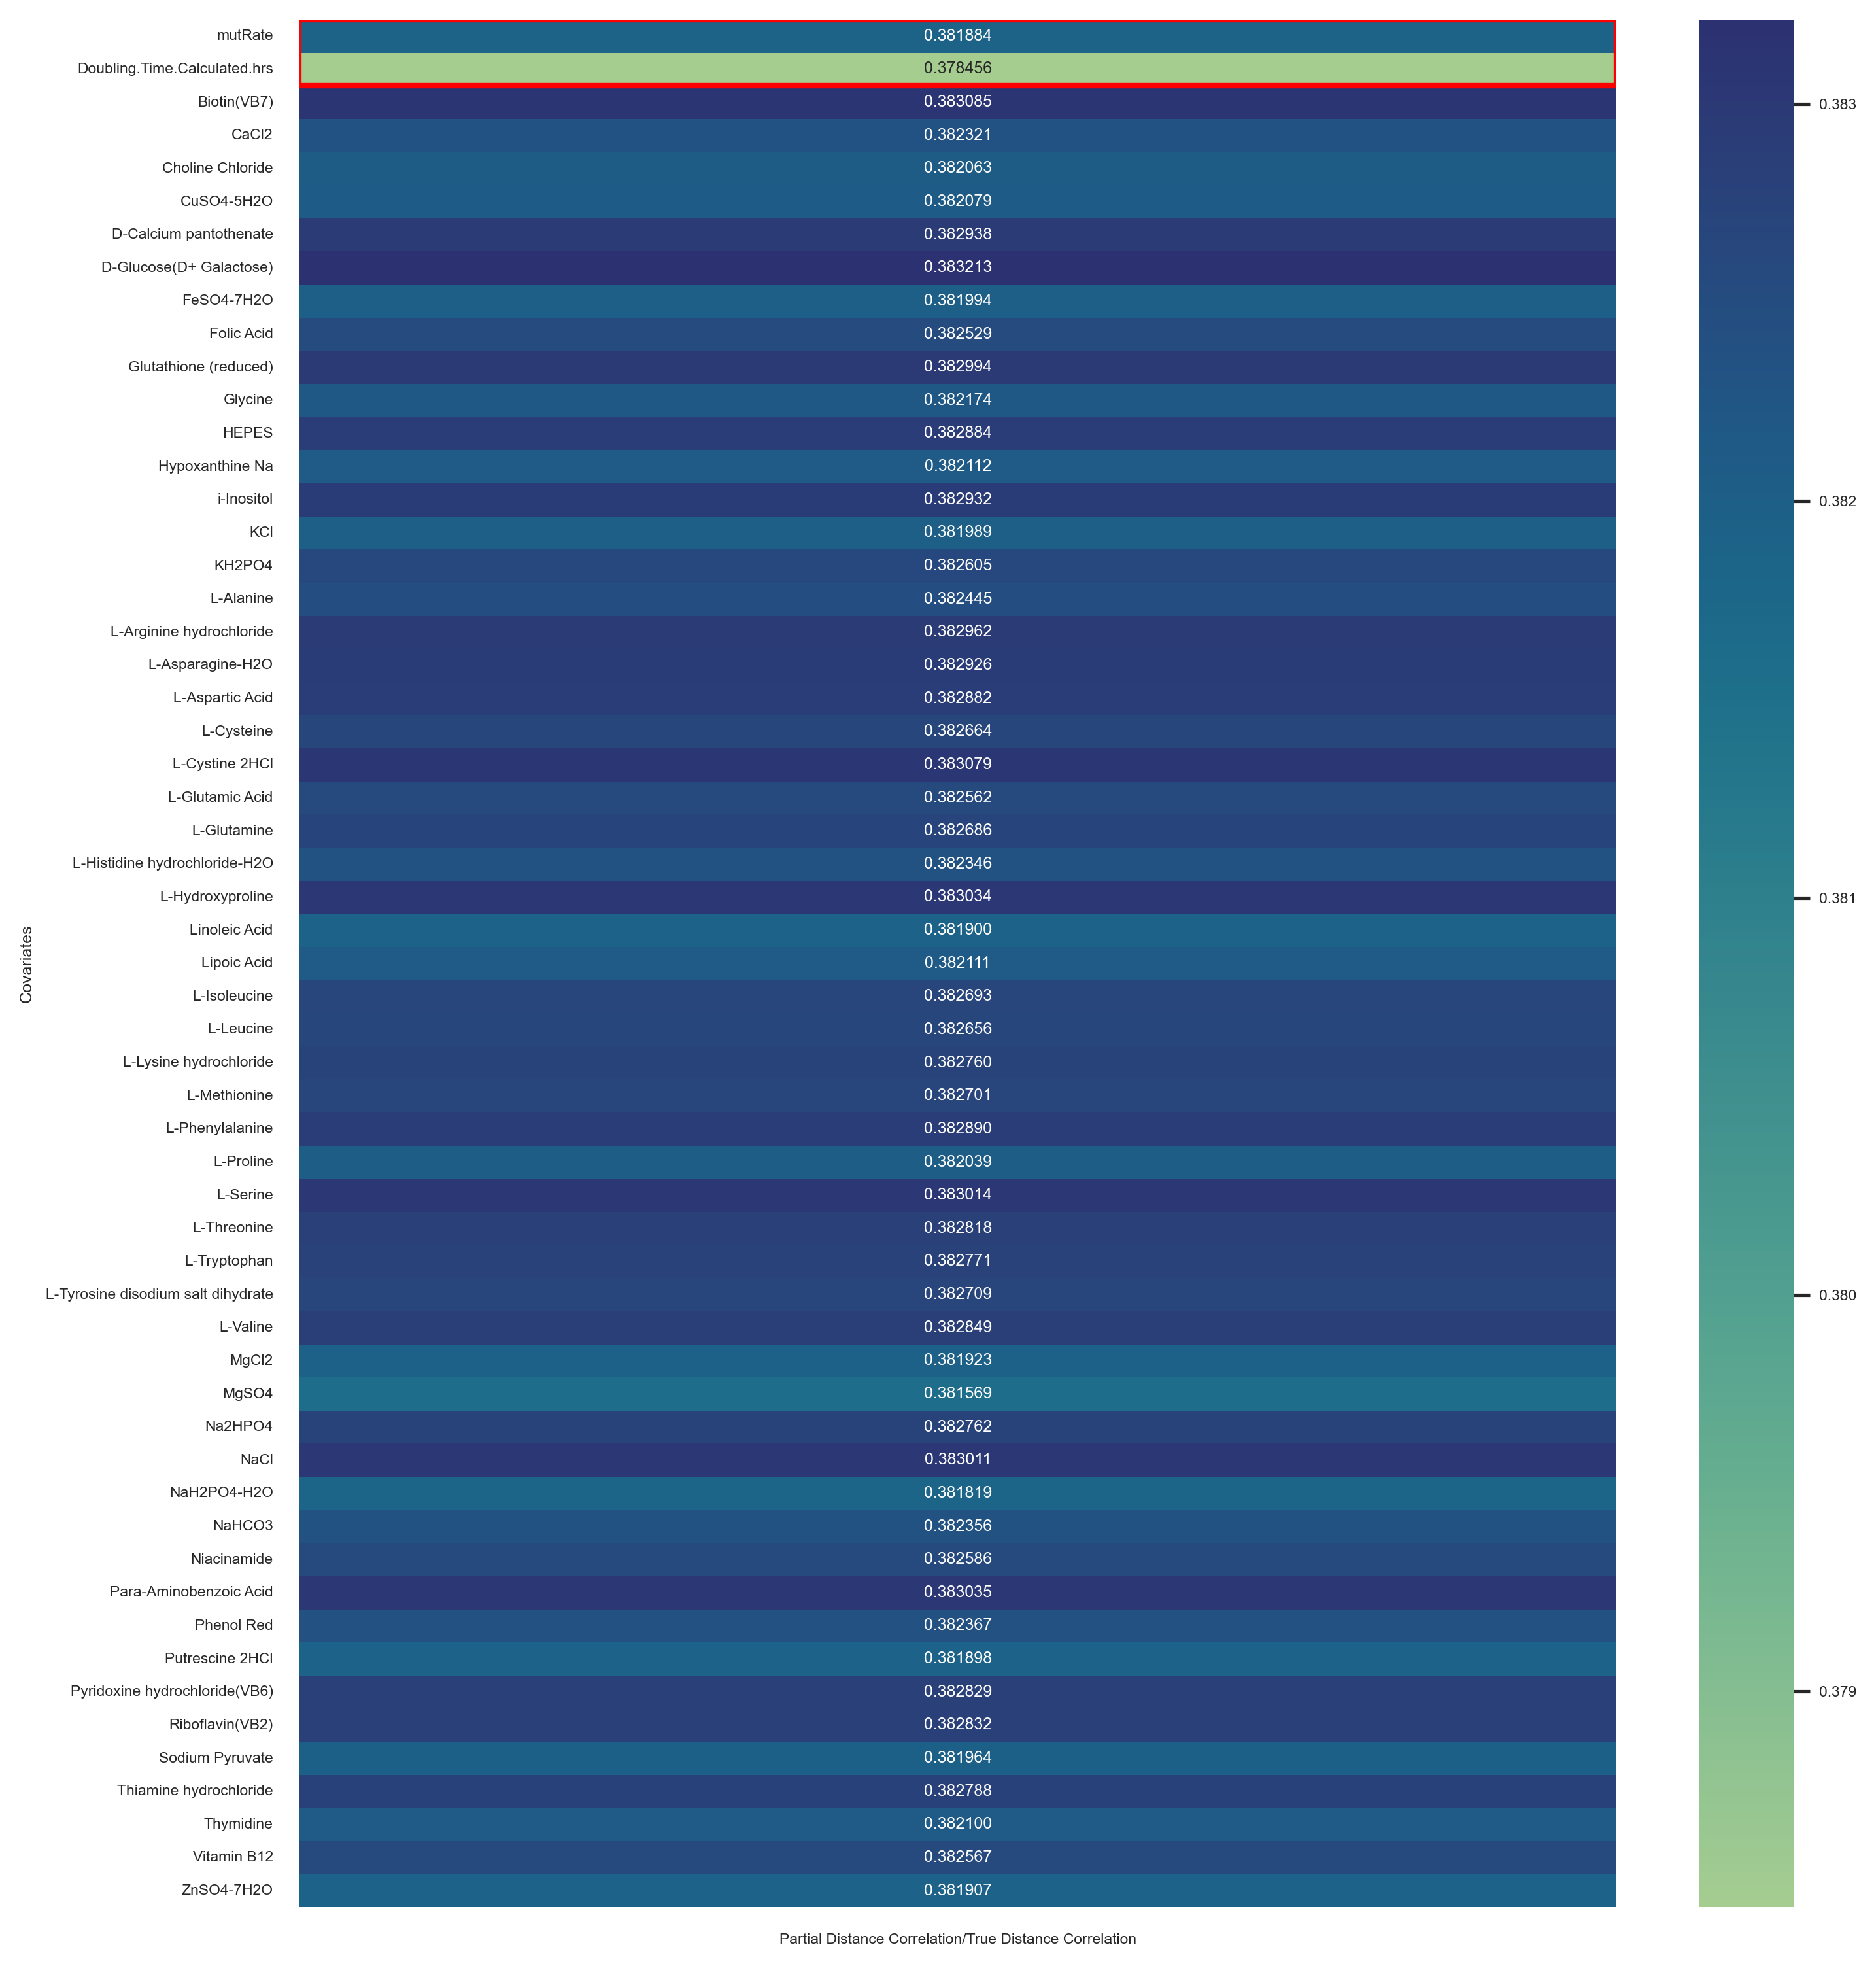

In [124]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
sns.set(font_scale=.5)
g = sns.heatmap(list_of_PDC, cmap = "crest",fmt = "f", annot = True)
g.set(ylabel = "Covariates")
ax = g
ax.add_patch(Rectangle((0, 0), 1, 2, fill=False, edgecolor='red', lw=2))
plt.tight_layout()
plt.show()

**Calculate PDC for all covariates at once**

In [125]:
meta_variables = ["mutRate", "Doubling.Time.Calculated.hrs"] + list(meta_data.iloc[-55:].index)
meta_data_analysis = meta_data.dropna(axis =1,subset = meta_variables)
all_pdc = calcPDC(rna_df[meta_data_analysis.columns].transpose().to_numpy(), 
         metabolite_df[meta_data_analysis.columns].transpose().to_numpy(), meta_data_analysis.loc[meta_variables].transpose().astype(float))
true_dc = calcOverlap(rna_df[meta_data_analysis.columns].transpose(), metabolite_df[meta_data_analysis.columns].transpose(), "DC")
print("PDC/DC with all covariates: %f" %(all_pdc/true_dc ))

PDC/DC with all covariates: 0.382961


In [126]:
meta_variables = list(meta_data.iloc[-55:].index)

meta_data_analysis = meta_data.dropna(axis =1,subset = meta_variables)
all_pdc = calcPDC(rna_df[meta_data_analysis.columns].transpose().to_numpy(), 
         metabolite_df[meta_data_analysis.columns].transpose().to_numpy(), meta_data_analysis.loc[meta_variables].transpose().astype(float))
true_dc = calcOverlap(rna_df[meta_data_analysis.columns].transpose(), metabolite_df[meta_data_analysis.columns].transpose(), "DC")
print("PDC/DC with media covariates: %f" %(all_pdc/true_dc ))

PDC/DC with media covariates: 0.433149
